In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
import scipy.linalg as la
import scipy.stats as sts
from matplotlib.pyplot import *

import jax
import jax.numpy as jnp

from copy import copy

In [2]:
%matplotlib widget

I0000 00:00:1701187240.031837       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


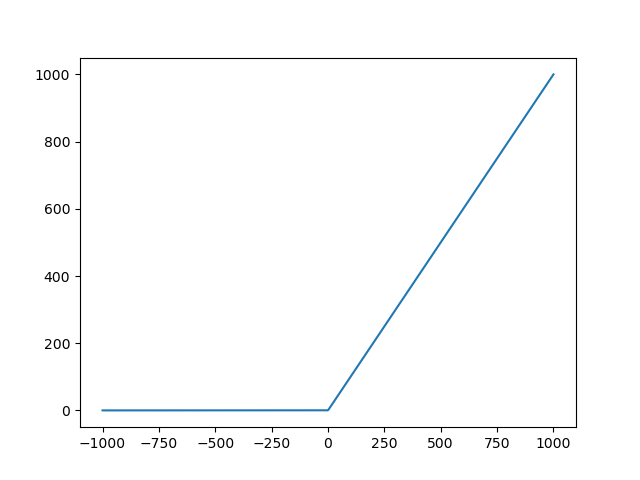

In [3]:
figure()
x= np.linspace(-1000,1000,10000)
plot(x,jax.nn.softplus(x))

In [4]:
jax.nn.softplus(0.08)

Array(0.7339469, dtype=float32, weak_type=True)

Text(0, 0.5, 'Cross Section')

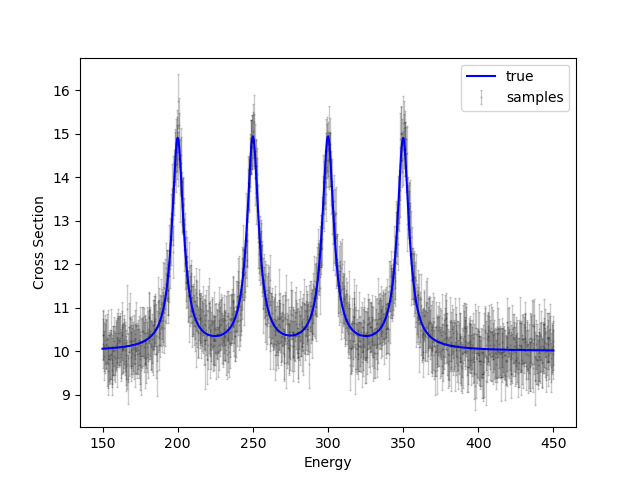

In [5]:
# Define the function using JAX NumPy
def Breit_Wigner(theta, E):
    Elam, Gg, Gn = jnp.split(theta, 3)
    Gg = jax.nn.softplus(Gg)
    Gn = jax.nn.softplus(Gn)

    xs = jnp.zeros(len(E))
    for iE, iGg, iGn in zip(Elam, Gg, Gn):
        xs += iGg * iGn / ((E - iE) ** 2 + (iGg + iGn) ** 2 / 4)
    return xs*10 + 10


idat = 1000
E = np.linspace(150,450,idat)


true_theta = np.array([200.0,250.0,300.0,350.0,
                       8.0,8.0,8.0,8.0,
                        1.0,1.0,1.0,1.0])
true_mod = Breit_Wigner(true_theta, E)
std = np.sqrt(true_mod)/10
sample_data = sts.norm.rvs(loc=true_mod, scale=std)
sample_cov = np.diag(np.ones(len(sample_data))*std)

# ifb = 10
# prior_theta = np.concatenate([np.linspace(10,100,ifb), np.ones(ifb)*8.0, np.ones(ifb)*4.0])
# prior_cov= np.diag(np.ones(ifb*2)*100)
# prior_mod = Breit_Wigner(prior_theta,E)

figure()
# plot(x, lorentz(x, 50, 10))
errorbar(E, sample_data, yerr=np.sqrt(np.diag(sample_cov)).flatten(),
          alpha=0.2, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='samples')
plot(E, true_mod, label='true', color='b')
# plot(E, prior_mod, label='prior')

legend()
xlabel('Energy')
ylabel('Cross Section')

In [6]:
from ATARI.theory.resonance_statistics import wigner_PDF
from scipy.stats import entropy

In [7]:


# Compute the gradient with respect to each element of theta using JAX
# grad_theta = jax.jacobian(Breit_Wigner, argnums=0)(true_theta, E)
# print("Gradient with respect to theta:", grad_theta)

def plotit(prior_theta, post_theta):
    Elam, Gg, Gn = jnp.split(prior_theta, 3)
    Elam_p, Gg_p, Gn_p = jnp.split(post_theta, 3)

    print(np.count_nonzero(Gn>1e-2))
    print(np.count_nonzero(Gn_p>1e-2))

    fig,axes = subplots(1,2,figsize=(12,4))

    # plot(x, lorentz(x, 50, 10))
    axes[0].plot(E, true_mod, label='true')
    axes[0].errorbar(E, sample_data, yerr=np.sqrt(np.diag(sample_cov)).flatten(), 
            alpha=0.2, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='samples')

    axes[0].plot(E, Breit_Wigner(prior_theta,E),lw=2, label='prior', color='orange')

    axes[0].plot(E, Breit_Wigner(post_theta, E), label='post', color='r')

    # for itheta in theta_log2:
    #     post_mod = Breit_Wigner(itheta, E)
    #     axes[0].plot(E, post_mod)

    axes[0].legend()

    bins=axes[1].hist(Gn, density=True, bins=50, color='orange', label="prior")
    bins=axes[1].hist(Gn_p, density=True, bins=50, alpha=0.5, color='r', label="post")

    return fig



def penalty(theta, lambda_penalty):
    Elam, Gg, Gn = jnp.split(theta, 3)

    # Calculate pairwise differences between parameter values
    parameter_differences = jnp.diff(Elam)

    # Calculate the PDF of the differences under a Gaussian distribution
    diff_pdf = wigner_PDF(parameter_differences, 4.0)

    # Estimate the PDF of the empirical data using KDE
    empirical_pdf = np.histogram(parameter_differences, bins=100, density=True)

    # PDF parameters for the Wigner semicircle distribution (e.g., based on your problem)
    wigner_pdf = wigner_PDF(empirical_pdf[1], 4.0)  # Assuming same bin edges as empirical data

    # Calculate the KL divergence
    kl_divergence = entropy(empirical_pdf[0], wigner_pdf)

    # Apply the penalty weight
    penalty = lambda_penalty * kl_divergence

    return penalty


def penalty_ires(theta,lambda_penalty):
    Elam, Gg, Gn = jnp.split(theta, 3)
    k_largest, _ = jax.lax.top_k(Gn, k=5)  # Get the 5 largest values within the group
    return lambda_penalty*(jnp.sum(jax.nn.softplus(Gn)) - jnp.sum(jax.nn.softplus(k_largest)))

def descend(theta, alpha, iterations=200, thresh=1e0, lambda_penalty=10.0, print_bool=False):
    saved_thetas = []
    chi2_log = []
    for i in range(iterations):

        # Compute predictions
        y_pred = Breit_Wigner(theta, E)
        chi2 = (sample_data-y_pred).T @ la.inv(sample_cov) @ (sample_data-y_pred)
        chi2_log.append(chi2.item())
        if print_bool:
            print(chi2)
        
        if i > 1:
            if chi2_log[i-1]-chi2_log[i] < thresh:
                print("Converged")
                break
            
        # Compute the gradient of the mean squared error with L1 penalty
        G = jax.jacobian(Breit_Wigner, argnums=0)(theta, E)     
        # penalty_gradient = jax.jacobian(penalty, argnums=0)(theta, lambda_penalty)
        penalty_gradient = jax.jacobian(penalty_ires, argnums=0)(theta, lambda_penalty)
        gradient = -(G.T@la.inv(sample_cov)@(sample_data-y_pred) - penalty_gradient)  / len(y_pred)
        
        # Update coefficients using gradient descent
        saved_thetas.append(copy(theta))
        theta -= alpha * gradient

    return saved_thetas, chi2_log

In [8]:
ifb = 50
prior_theta = np.concatenate([np.linspace(min(E),max(E),ifb),# np.array([210.0,240.0,220.0, 225.0, 245.0])
                              np.ones(ifb)*4.0, 
                              np.ones(ifb)*1.0])

# theta = copy(prior_theta)

# Learning rate and number of iterations
alpha = 0.1
alpha = np.concatenate([np.ones(ifb)*alpha, np.ones(ifb)*alpha, np.ones(ifb)*alpha])

theta_log, chi2_log = descend(copy(prior_theta), alpha, iterations=100, lambda_penalty=1.0, thresh=1e0, print_bool=True)

255513.9
205005.06
165389.48
134688.48
110989.62
92645.44
78340.19
67069.4
58085.707
50838.125
44921.527
40036.49
35959.99
32524.355
29602.295
27095.975
24929.588
23043.553
21390.814
19933.787
18642.006
17490.844
16460.08
15532.996
14695.717
13936.606
13245.905
12615.292
12037.757
11507.235
11018.556
10567.213
10149.32
9761.493
9400.762
9064.543
8750.526
8456.69
8181.245
7922.5767
7679.2812
7450.079
7233.8306
7029.511
6836.188
6653.0337
6479.302
6314.305
6157.4204
6008.08
5865.766
5730.0137
5600.3906
5476.4927
5357.9688
5244.4766
5135.71
5031.393
4931.253
4835.055
4742.5728
4653.605
4567.939
4485.415
4405.854
4329.105
4255.0273
4183.482
4114.339
4047.479
3982.7996
3920.1929
3859.5583
3800.808
3743.8582
3688.627
3635.028
3583.003
3532.477
3483.3853
3435.678
3389.2825
3344.154
3300.244
3257.4993
3215.8804
3175.3347
3135.8271
3097.3162
3059.7673
3023.1426
2987.4102
2952.5403
2918.4927
2885.251
2852.7817
2821.0564
2790.0527
2759.7466
2730.119


In [89]:
# jax.nn.softplus(-2.5)

print(f"True Chi2: {(sample_data-Breit_Wigner(true_theta,E)).T @ la.inv(sample_cov) @ (sample_data-Breit_Wigner(true_theta,E))}")
print(f"Est Chi2: {chi2_log[-1]}")

True Chi2: 311.9520568847656
Est Chi2: 2698.1845703125


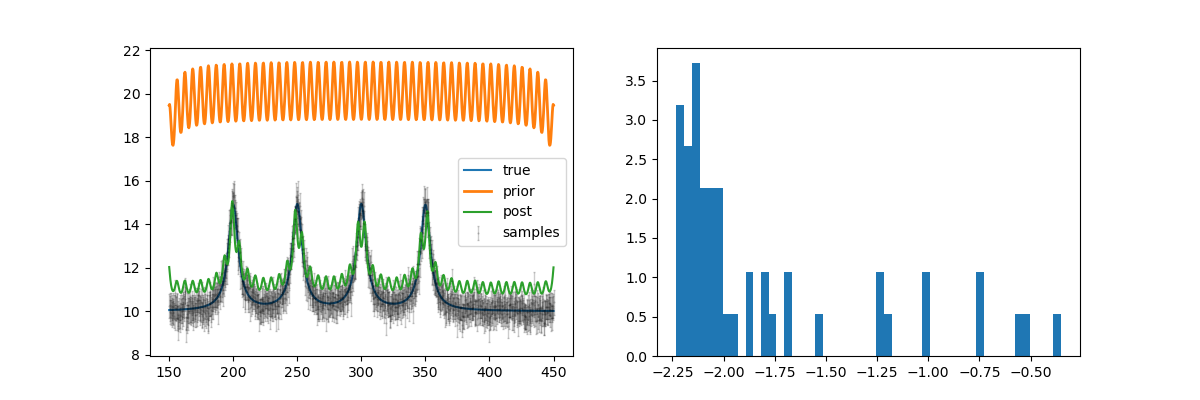

In [90]:
Elam, Gg, Gn = jnp.split(theta_log[-1], 3)


fig,axes = subplots(1,2,figsize=(12,4))

# plot(x, lorentz(x, 50, 10))
axes[0].plot(E, true_mod, label='true')
axes[0].errorbar(E, sample_data, yerr=np.sqrt(np.diag(sample_cov)).flatten(), 
          alpha=0.2, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='samples')

axes[0].plot(E, Breit_Wigner(prior_theta,E),lw=2, label='prior')

post_mod = Breit_Wigner(theta_log[-1], E)
axes[0].plot(E, post_mod, label='post')
axes[0].legend()

bins=axes[1].hist(Gn, density=True, bins=50)

In [72]:
Elam, Gg, Gn = jnp.split(theta_log[-1], 3)
mask = Gn>-2.5
print(np.count_nonzero(mask))
reduced_theta = np.concatenate([Elam[mask], Gg[mask], Gn[mask]])
ifb2 = np.count_nonzero(mask)

9


In [86]:
alpha = 1.0
alpha = np.concatenate([np.ones(ifb2)*alpha, np.ones(ifb2)*alpha, np.ones(ifb2)*alpha])
theta_log2, chi2_log2 = descend(copy(reduced_theta), alpha, iterations=500, lambda_penalty=1000.0, thresh=1e0, print_bool=True)

834.5734
850.4814
861.9921
Converged


1
1


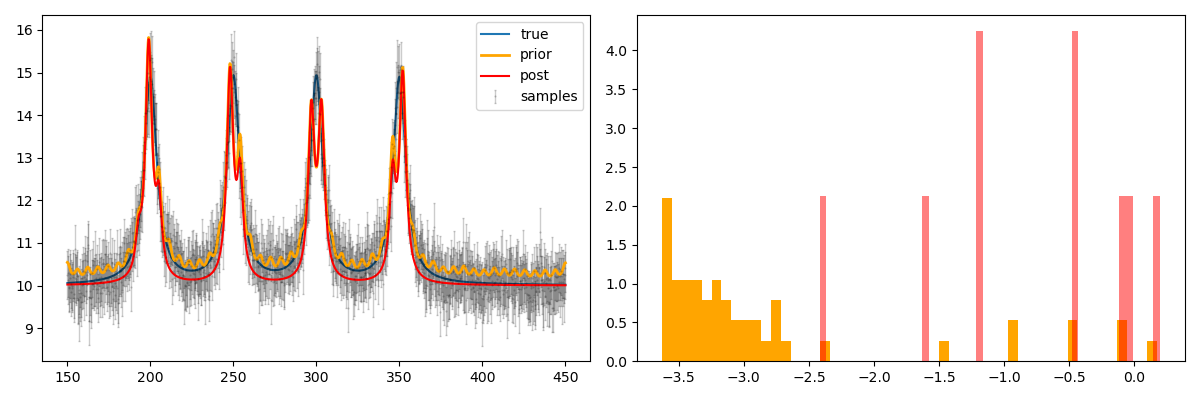

In [87]:
fig = plotit(theta_log[-1], theta_log2[-1])
fig.tight_layout()

In [65]:
# jnp.split(theta_log2[-1], 3)
Elam, Gg, Gn= jnp.split(theta_log[-1], 3)
weights = Breit_Wigner(theta_log[-1],Elam)

alpha = 0.01
alpha = np.concatenate([np.ones(ifb)*alpha, np.ones(ifb)*alpha, np.ones(ifb)*alpha])
theta_log2a, chi2_log2a = descend(copy(theta_log[-1]), alpha, iterations=50, lambda_lasso=2000.0, thresh=-1000, print_bool=True, adaptive=True, weights=np.concatenate([np.ones_like(Elam),np.ones_like(Gg), weights]))

310.69168
311.5045
314.29236
318.74197
323.41324
329.07175
334.43036
339.69235
345.40396
350.57867
355.67725
359.2171
365.65143
369.20517
373.81378
377.01367
380.38593
385.8066
392.07477
392.2319
396.41653
400.56247
401.46292
407.84848
409.39276
411.23175
416.98322
419.0008
422.60056
424.27292
425.64713
426.87738
429.2865
432.45215
435.49097
437.72122
440.0989
440.33636
442.78232
441.34985
443.79666
446.2501
448.34912
448.2468
450.1429
452.4618
452.49734
451.3588
453.15393
451.33115


51
9


/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_8581/1256450528.py:46: RuntimeWarning: invalid value encountered in log10
  bins=axes[1].hist(np.log10(Gn), density=True, bins=50, color='orange', label="prior")
/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_8581/1256450528.py:47: RuntimeWarning: invalid value encountered in log10
  bins=axes[1].hist(np.log10(Gn_p), density=True, bins=50, alpha=0.5, color='r', label="post")
/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_8581/2473152328.py:7: RuntimeWarning: invalid value encountered in log10
  axes[1].hist(np.log10(Gna), label="adaptive", color='g', alpha=0.5, density=True, bins=50)


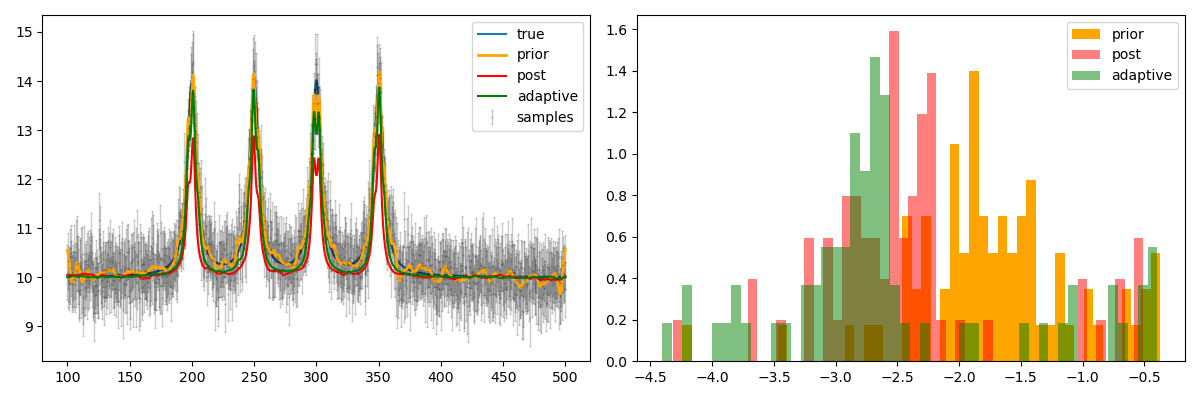

In [67]:
fig = plotit(theta_log[-1], theta_log2[-1])
axes = fig.get_axes()

axes[0].plot(E, Breit_Wigner(theta_log2a[-1],E), label="adaptive", color='g')

Elama, Gga, Gna = jnp.split(theta_log2a[-1], 3)
axes[1].hist(np.log10(Gna), label="adaptive", color='g', alpha=0.5, density=True, bins=50)

fig.tight_layout()
axes[0].legend()
axes[1].legend()

15


In [95]:
print(Elam[mask])
print(Gn[mask])

[196.9722  201.007   205.0505  237.37373 245.45529 249.4957  253.5345
 257.57574 293.9394  297.9822  302.0172  306.0606  346.46466 350.50504
 354.5452 ]
[0.22633435 0.3834759  0.07564515 0.01271021 0.089206   0.3963227
 0.18317613 0.01121861 0.04691568 0.30477586 0.3053327  0.03406148
 0.1898329  0.4049155  0.08269735]


In [122]:
alpha = 0.01
ifb_new = 15
alpha = np.concatenate([np.ones(ifb_new)*alpha, np.ones(ifb_new)*alpha, np.ones(ifb_new)*alpha]) #np.concatenate([np.ones_like(Elam),np.ones_like(Gg), weights])
# theta_log3, chi2_log3 = descend(copy(reduced_theta), alpha, iterations=100, lambda_lasso=500.0, thresh=-1000, print_bool=True, adaptive=False, weights=np.concatenate([np.ones_like(Elam),np.ones_like(Gg), np.ones_like(Gn)]))
theta_log3, chi2_log3 = descend_penalty(copy(reduced_theta), alpha, iterations=25, thresh=-100, penscale=1000, print_bool=True)

483.65173
508.166
528.3681
545.0605
563.99384
579.3323
589.3343
598.2568
610.36615
625.3452
641.60297
648.5075
654.478
644.16254
633.52124
627.70184
626.25354
628.7772
634.9121
644.3383
656.76624
671.9356
689.6107
709.0254
723.0833


15
7


/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_8581/771934762.py:46: RuntimeWarning: invalid value encountered in log10
  bins=axes[1].hist(np.log10(Gn), density=True, bins=50, color='orange', label="prior")
/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_8581/771934762.py:47: RuntimeWarning: invalid value encountered in log10
  bins=axes[1].hist(np.log10(Gn_p), density=True, bins=50, alpha=0.5, color='r', label="post")


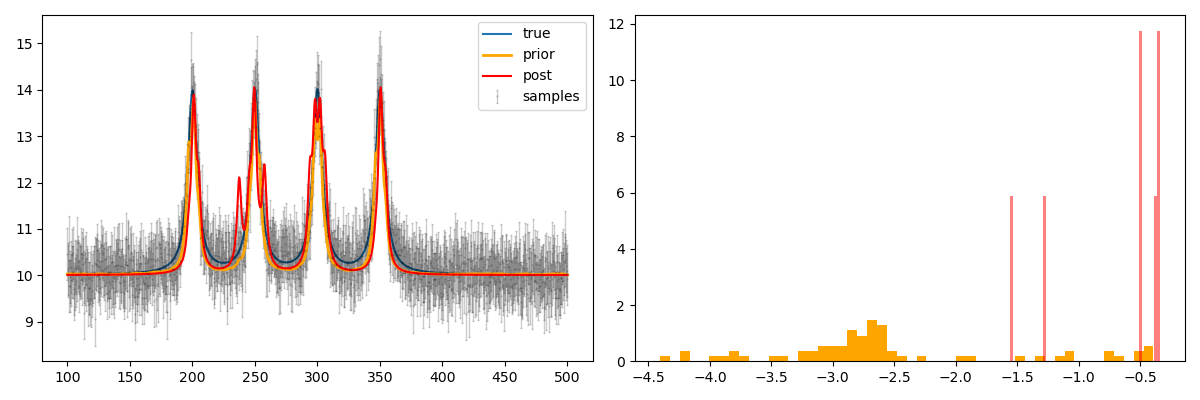

In [123]:
fig = plotit(theta_log2a[-1], theta_log3[-1])

# axes = fig.get_axes()

# for i in range(len(theta_log3)):
#     axes[0].plot(E, Breit_Wigner(theta_log3[i], E))

fig.tight_layout()

In [ ]:
weights3 = Breit_Wigner(theta_log3[-1],Elam)

alpha = 0.01
alpha = np.concatenate([np.ones(ifb)*alpha, np.ones(ifb)*alpha, np.ones(ifb)*alpha])
theta_log3a, chi2_log3a = descend(copy(theta_log3[-1]), alpha, iterations=25, lambda_lasso=1000.0, thresh=-1000, print_bool=True, adaptive=False, weights=np.concatenate([np.ones_like(Elam),
                                                                                                                                                                          np.ones_like(Gg), 
                                                                                                                                                                          weights3]))


Array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.73132324e-03,  7.47680664e-04,  3.96728516e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -7.78198242e-04,  2.09045410e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.10571289e-03,  1.34277344e-03,  0.00000000e+00,
        0.00000000e+00,  

10
24


/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_7273/2876308978.py:23: RuntimeWarning: invalid value encountered in log10
  bins=axes[1].hist(np.log10(Gn), density=True, bins=50, color='orange')
/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_7273/2876308978.py:24: RuntimeWarning: invalid value encountered in log10
  bins=axes[1].hist(np.log10(Gna), density=True, bins=50, alpha=0.5, color='r')


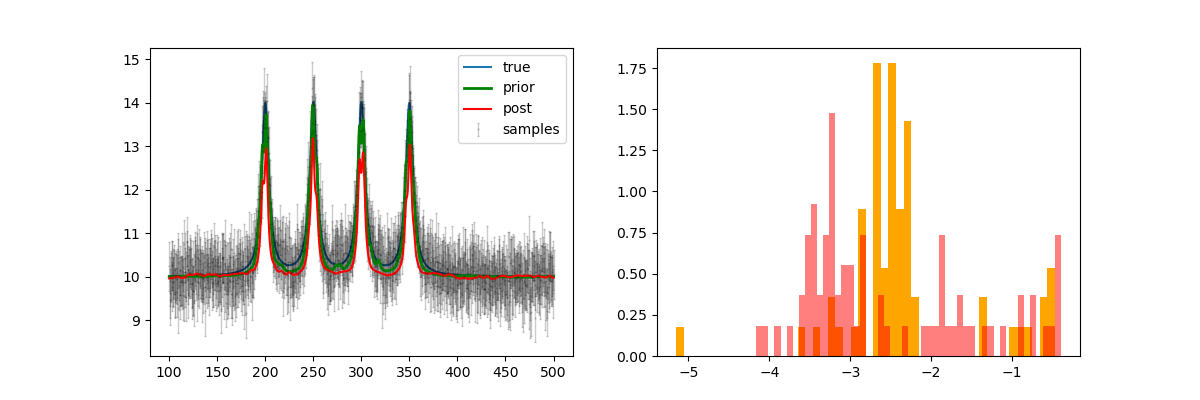

NameError: name 'theta' is not defined

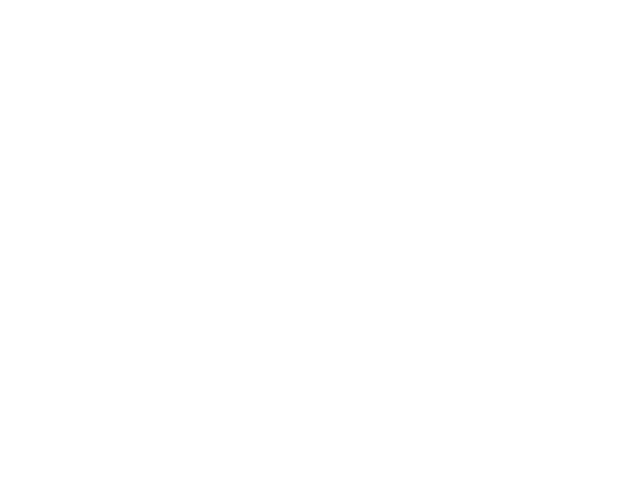

In [ ]:
figure()
Elam, Gg, Gn = jnp.split(theta, 3)
bins = hist(np.log10(jax.nn.softplus(Gn)), density=True, bins=50)